In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pylab import *
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score

In [3]:
X_train = pd.read_csv('./data/nba/X_train.csv')
y_train = pd.read_csv('./data/nba/y_train.csv')

X_test = pd.read_csv('./data/nba/X_test.csv')
print(X_train.shape)
print(X_train.columns)
print(y_train.columns)
print(X_train[:4])
print(y_train[:4])

(52399, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')
   PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
0       2         557        15.5         0         0.7        2.1         2   
1       2         151        20.1         0         0.8        2.7         2   
2       3         448        14.2         0         0.8        5.1         2   
3       1         279        10.6         0         0.6        1.9         2   

   CLOSE_DEF_DIST  
0             0.0  
1             3.4  
2             0.1  
3             2.7  
   FGM
0    1
1    1
2    0
3    1


In [4]:
def pd2np(df):
    return df.as_matrix()

In [5]:
X_train = pd2np(X_train)
y_train = pd2np(y_train)

X_test = pd2np(X_test)
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(52399, 8)


D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Split Data

我把training data set切成兩個部分，分別為training set和validation set。

In [6]:
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.4, random_state=50)
sc_x = StandardScaler()
Xtr_std = sc_x.fit_transform(X_train2)
Xv_std = sc_x.fit_transform(X_valid)
Xte_std = sc_x.fit_transform(X_test)
print('Training set points:{}'.format(Xtr_std.shape[0]))
print('Validation set points:{}'.format(Xv_std.shape[0]))
print('Testing set points:{}'.format(Xte_std.shape[0]))

Training set points:31439
Validation set points:20960
Testing set points:13100


# Feature Selection

我利用random forest來找出feature各自的重要性，並選出前三個組成新的data，分別為'GAME_CLOCK'、'SHOT_DIST'和'SHOT_CLOCK'。

In [7]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',n_estimators=200,random_state=1,n_jobs=2)
forest.fit(Xtr_std, y_train2)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print(indices)
print(importances[indices])
importances_sort=importances[indices]
Xtr_cho = Xtr_std[:,indices[:3]]
Xv_cho = Xv_std[:,indices[:3]]
Xte_cho = Xte_std[:,indices[:3]]

D:\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[1 5 2 7 4 0 3 6]
[0.20097321 0.19893617 0.17817432 0.17151347 0.14101623 0.05228013
 0.0498692  0.00723728]


# Model-Ridge and Lasso

這個部分我使用RidgeClassifier()以及Lasso()來進行training，由於不知道合適的degree和alpha值為多少，因此利用迴圈的方式來找，一開始想用mse最低來找，後來發現mse的值沒有差很多看不太出來，所以決定用accyracy來看，由最下面印出accuracy的地方可以看到最高的是當degree=4、alpha=0.01時，用Lasso得出0.62的accuracy，這也是全部我試過的model中最高的。

In [8]:
from sklearn.linear_model import RidgeClassifier
mse_train =[]
mse_test = []

for d in range(1, 6):
    print('\n[Degree = %d]' % d ) 
    poly = PolynomialFeatures(degree=d)
    Xtr_poly = poly.fit_transform(Xtr_cho)
    Xv_poly = poly.fit_transform(Xv_cho)
    print('--RIDGE--')    
    for a in [0, 1, 10, 100, 1000]:
        lr_rg=RidgeClassifier(alpha=a)
        lr_rg.fit(Xtr_poly, y_train2)
        y_train_pred = lr_rg.predict(Xtr_poly)
        y_test_pred = lr_rg.predict(Xv_poly)
        print('[Alpha = %d]' % a )
        print('MSE train: %.4f, test: %.4f' % (mean_squared_error(y_train2, y_train_pred),mean_squared_error(y_valid, y_test_pred)))
        print('Accuracy(train): %.2f' % accuracy_score(y_train2, y_train_pred))
        print('Accuracy(valid): %.2f' % accuracy_score(y_valid, y_test_pred))
    print('--LASSO--')
    for b in [0.001, 0.01, 0.1, 1, 10]:
        lr_rg = Lasso(alpha=b)      
        lr_rg.fit(Xtr_poly, y_train2)
        y_train_pred = lr_rg.predict(Xtr_poly)
        y_test_pred = lr_rg.predict(Xv_poly)
        y_train_pred = np.where(y_train_pred >= 0.5, 1, 0)
        y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)  
        print('[Alpha = %.2f]' % b )
        print('MSE train: %.4f, test: %.4f' % (mean_squared_error(y_train2, y_train_pred),mean_squared_error(y_valid, y_test_pred)))
        print('Accuracy(train): %.2f' % accuracy_score(y_train2, y_train_pred))
        print('Accuracy(valid): %.2f' % accuracy_score(y_valid, y_test_pred))


[Degree = 1]
--RIDGE--
[Alpha = 0]
MSE train: 0.4064, test: 0.3972
Accuracy(train): 0.59
Accuracy(valid): 0.60
[Alpha = 1]
MSE train: 0.4064, test: 0.3972
Accuracy(train): 0.59
Accuracy(valid): 0.60
[Alpha = 10]
MSE train: 0.4064, test: 0.3972
Accuracy(train): 0.59
Accuracy(valid): 0.60
[Alpha = 100]
MSE train: 0.4063, test: 0.3971
Accuracy(train): 0.59
Accuracy(valid): 0.60
[Alpha = 1000]
MSE train: 0.4058, test: 0.3962
Accuracy(train): 0.59
Accuracy(valid): 0.60
--LASSO--
[Alpha = 0.00]
MSE train: 0.4063, test: 0.3975
Accuracy(train): 0.59
Accuracy(valid): 0.60
[Alpha = 0.01]
MSE train: 0.4050, test: 0.3954
Accuracy(train): 0.60
Accuracy(valid): 0.60
[Alpha = 0.10]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55
[Alpha = 1.00]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55
[Alpha = 10.00]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55

[Degree = 2]
--RIDGE--
[Alpha = 0]
MSE train: 0.4015, test: 0.3

D:\Miniconda3\lib\site-packages\sklearn\linear_model\ridge.py:810: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[Alpha = 10]
MSE train: 0.4014, test: 0.3923
Accuracy(train): 0.60
Accuracy(valid): 0.61
[Alpha = 100]
MSE train: 0.4015, test: 0.3921
Accuracy(train): 0.60
Accuracy(valid): 0.61
[Alpha = 1000]
MSE train: 0.4012, test: 0.3928
Accuracy(train): 0.60
Accuracy(valid): 0.61
--LASSO--
[Alpha = 0.00]
MSE train: 0.4019, test: 0.3926
Accuracy(train): 0.60
Accuracy(valid): 0.61
[Alpha = 0.01]
MSE train: 0.4030, test: 0.3929
Accuracy(train): 0.60
Accuracy(valid): 0.61
[Alpha = 0.10]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55
[Alpha = 1.00]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55
[Alpha = 10.00]
MSE train: 0.4589, test: 0.4523
Accuracy(train): 0.54
Accuracy(valid): 0.55

[Degree = 3]
--RIDGE--
[Alpha = 0]
MSE train: 0.3924, test: 0.3875
Accuracy(train): 0.61
Accuracy(valid): 0.61
[Alpha = 1]
MSE train: 0.3924, test: 0.3875
Accuracy(train): 0.61
Accuracy(valid): 0.61
[Alpha = 10]
MSE train: 0.3924, test: 0.3875
Accuracy(train): 0

## Write csv file

使用結果最好的model來寫y_pred.csv檔。

In [9]:
import csv
d=4
poly = PolynomialFeatures(degree=d)
Xtr_poly = poly.fit_transform(Xtr_cho)
Xv_poly = poly.fit_transform(Xv_cho)
Xte_poly = poly.fit_transform(Xte_cho)
lr_rg = Lasso(alpha=0.01)      
lr_rg.fit(Xtr_poly, y_train2)
y_train_pred = lr_rg.predict(Xtr_poly)
y_valid_pred = lr_rg.predict(Xv_poly)
y_test_pred = lr_rg.predict(Xte_poly)
y_train_pred = np.where(y_train_pred >= 0.5, 1, 0)
y_valid_pred = np.where(y_valid_pred >= 0.5, 1, 0)
y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)
print(y_test_pred)
file = open('y_pred.csv', 'w')
csvCursor = csv.writer(file)
csvCursor.writerow(y_test_pred)

[0 0 1 ... 0 0 0]


26201

## Plot Learning Curve

從learning curve圖中的結果可以得知沒有overfit。

In [10]:
def mse(model, X, y):
    pred = np.where(model.predict(X)>=0.5, 1, 0)
    pred = pred[:, np.newaxis]
    return ((pred - y)**2).mean()

D:\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Miniconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


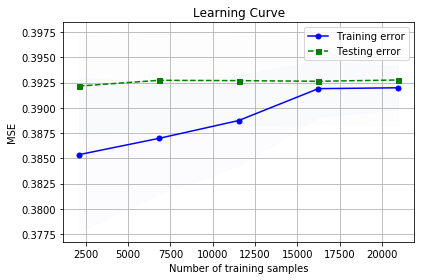

In [11]:
from sklearn.learning_curve import learning_curve
#sigma = 1
poly = PolynomialFeatures(degree=4)
Xtr_poly = poly.fit_transform(Xtr_cho)
Xv_poly = poly.fit_transform(Xv_cho)
#lr_rg = LinearRegression()
lr_rg = Lasso(alpha=0.01)
#lr_rg.fit(Xtr_poly, y_train2)
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_rg, X=Xtr_poly, 
                                                        y=y_train2, scoring=mse)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5,
    label='Training error')

plt.fill_between(train_sizes,
    train_mean+train_std,
    train_mean-train_std,
    alpha=0.01, color='blue')

plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Testing error')
plt.fill_between(train_sizes,
    test_mean+test_std,
    test_mean-test_std,
    alpha=0.01, color='green')

#plt.hlines(y=0.5, xmin=0, xmax=20000, color='red', linewidth=2, linestyle='--')

plt.title('Learning Curve')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('MSE')
plt.legend(loc='upper right')
#plt.ylim([0, 1])
plt.tight_layout()
#plt.savefig('./output/fig-learning-curve-%d.png' % d, dpi=300)
plt.show()

# Model-Linear Regression

第二個model我是嘗試最簡單的linear regression，在accuracy的部分並沒有到Lasso那麼高。

In [12]:
cubic = PolynomialFeatures(degree=3)
cubic.fit(Xtr_cho)
Xtr_lin = cubic.transform(Xtr_cho)
Xv_lin = cubic.transform(Xv_cho)
Xte_lin = cubic.transform(Xte_cho)
s=StandardScaler()
s.fit(Xtr_lin)
Xtr_linstd = s.transform(Xtr_lin)
Xv_linstd = s.transform(Xv_lin)
Xte_linstd = s.transform(Xte_lin)
cubic_regr = LinearRegression()
cubic_regr = cubic_regr.fit(Xtr_linstd, y_train2)
y_train_pred = cubic_regr.predict(Xtr_linstd)
y_test_pred = cubic_regr.predict(Xv_linstd)
y_train_pred = np.where(y_train_pred >= 0.5, 1, 0)
y_test_pred = np.where(y_test_pred >= 0.5, 1, 0)  
print('Accuracy(train): %.2f' % accuracy_score(y_train2, y_train_pred))
print('Accuracy(valid): %.2f' % accuracy_score(y_valid, y_test_pred))

Accuracy(train): 0.61
Accuracy(valid): 0.61


# Model-Random Forest

我另外也嘗試了random forest的model，training accuracy的結果非常好但用validation set測的accuracy的結果卻不太理想。

In [13]:
forest_forest = RandomForestClassifier(n_estimators=100,n_jobs=2)
forest_forest.fit(Xtr_cho, y_train2)
y_train_pred = forest_forest.predict(Xtr_cho)
y_test_pred = forest_forest.predict(Xv_cho)
print('Accuracy(train): %.2f' % accuracy_score(y_train2, y_train_pred))
print('Accuracy(valid): %.2f' % accuracy_score(y_valid, y_test_pred))

D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy(train): 1.00
Accuracy(valid): 0.57


# Report

### What I did in this assignment?

1.Validation Set and adjust the variables of splittng data.

2.Use 'Random Forest' to select the three most important features of data.('GAME_CLOCK'、'SHOT_DIST'和'SHOT_CLOCK')

3.Use PolymialFeatures to preprocess the data.

4.Use models including Ridge, Lasso, Linear regression, and Random forest to train the data, and use 'accuracy' and 'mse' to evaluate the data preprocessing data and models.

5.The result of model: 

    -Ridge(valid accuracy=0.61)
    -Lasso(valid accuracy=0.62)
    -Linear Regression(valid accuracy=0.61)
    -Random Forest(valid accuracy=0.57)